# Noise channel w/ quantum trajectories (Monte Carlo)

## Imports

In [1]:
from copy import copy
from typing import Union

import numpy as np

from jax import numpy as jnp
from jax import vmap, jit, value_and_grad
from jax.random import PRNGKey, choice

import qujax
from qujax import (
    get_params_to_densitytensor_func,
    get_statetensor_to_expectation_func,
    get_densitytensor_to_expectation_func,
    all_zeros_statetensor,
)
from qujax.experimental.statetensor import get_params_to_statetensor_func, get_default_gates

import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Motivation

Here, we will aim to simulate a quantum circuit suffering from a noise channel using only statevector simulation, as opposed to using density matrices as is done in [this notebook](https://github.com/CQCL/qujax/blob/develop/examples/noise_channel.ipynb). 

A reason to do this is that density matrices require quadratically more resources to store than statevectors. Indeed, for $N$ qubits, a generic statevector requires $2^N$ complex numbers to specify, while for density matrices it requires $2^{2N}$ complex numbers. This makes it so that for a fixed amount of memory, statevector simulation can be performed for twice the number of qubits, as the following plot illustrates:


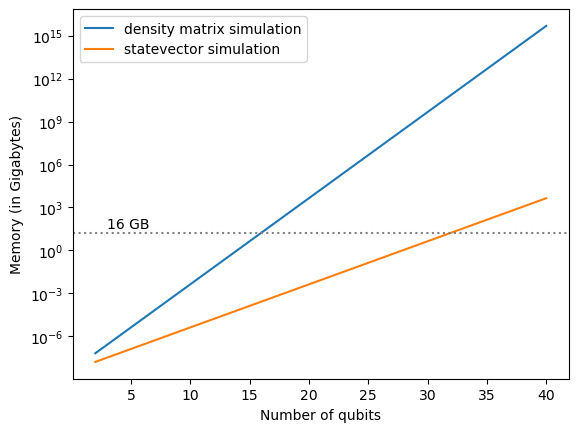

In [2]:
nr_of_qubits = np.array(range(2, 41, 2))


def log2_memory_needed_to_store_coefficients(
    nr_of_qubits: Union[np.ndarray, int]
) -> Union[np.ndarray, float]:
    """
    Given `nr_of_qubits`, returns memory needed to store a statevector having that number of qubits.

    The logarithm is used to avoid excessively large numbers which can not be stored in a
    np.float64.
    """
    log2_nr_of_coefficients = nr_of_qubits

    # Get nr of bits needed to store complex numbers representing coefficients
    # Note that 2**5 = 128, which is the size of a complex floating point number
    log2_bits = log2_nr_of_coefficients + 5

    # Note that 2**3 = 8, which is the nr of bits in a byte
    log2_bytes = log2_bits - 3

    log2_gigabytes = log2_bytes - np.log2(1e9)

    return log2_gigabytes


# Plot memory needed to store density matrix for different nr of qubits
plt.plot(
    nr_of_qubits,
    2 ** log2_memory_needed_to_store_coefficients(2 * nr_of_qubits),
    label="density matrix simulation",
)
# Plot memory needed to store statevector for different nr of qubits
plt.plot(
    nr_of_qubits,
    2 ** log2_memory_needed_to_store_coefficients(nr_of_qubits),
    label="statevector simulation",
)

plt.legend(loc="upper left")
plt.yscale("log")
plt.ylabel("Memory (in Gigabytes)")
plt.xlabel("Number of qubits")
plt.axhline(16, c="gray", ls=":")
plt.text(3, 35, "16 GB");

## Theory

Suppose we wish to apply a $k$-qubit unitary matrix (gate) $U$, but our system is affected by a depolarising noise channel. Suppose also that we are interested in computing the expectation value of some operator $O$. This noise channel, in the density matrix formulation, can be written as

\begin{equation}
\sigma = \mathcal{D}_{p,U}[\rho] = p_0 U\rho U^\dagger + \sum_{i=1}^{4^k} p_i P_i \rho P_i^\dagger, \tag{1}
\end{equation}

The expectation value we wish to compute is $\text{tr}(\sigma O)$. Assuming a pure initial state $\rho_0 = \ket{\psi_0}\bra{\psi_0}$, this expectation can be expressed as

\begin{align}
&\text{tr}\,\left(\left[p_0 U\rho_0 U^\dagger + \sum_{i=1}^{4^k} p_i P_i \rho_0 P_i^\dagger \right] O \right ) \\
&= p_0 \text{tr}\,\left(U\rho_0 U^\dagger O \right )  + \sum_{i=1}^{4^k} p_i \text{tr} \, \left( P_i \rho_0 P_i^\dagger  O \right ) \\
&= p_0 \text{tr}\,\left(U\rho_0 U^\dagger O \right )  + \sum_{i=1}^{4^k} p_i \text{tr} \, \left( P_i \rho_0 P_i^\dagger  O \right ) \\
&= p_0 \langle U\ket{\psi_0} \rangle_O  + \sum_{i=1}^{4^k} p_i \langle P_i\ket{\psi_0} \rangle_O \\
\end{align}
where $P_i \in \{I, X, Y, Z\}^{\otimes k}$ and $\sum_{i=0}^{4^k} p_i = 1$.

The above equality means that we can sample expectation values of several pure state simulations according to the probability vector $[p_0,..., p_{4^k}]$ to arrive at the expectation value of the operator $O$ under the noise model, which would otherwise require mixed state simulation. This technique is sometimes called **quantum trajectories** or **Monte Carlo (wavefunction) simulation**.


Note that, in practice, we will have multiple noisy gates in our circuit. To apply this technique, every time we encounter a noisy gate, we sample and apply a gate according to the probability vector $[p_0,..., p_{4^k}]$.

## Simulation

For simplicity, we will assume single qubit gates are noiseless and two qubit gates are affected by a depolarising noise channel with probability vector 

$$p = [(1-p_0)/4^k, ..., (1-p_0)/4^k],$$

where $p_0 = 0.99$

### Constructing 2-qubit Pauli operators

First let's construct the set of two qubit Pauli combinations $\{I, X, Y, Z\}^{\otimes 2}$

In [3]:
paulis = {
    "I": qujax.gates.I,
    "X": qujax.gates.X,
    "Y": qujax.gates.Y,
    "Z": qujax.gates.Z,
}
paulis

{'I': Array([[1., 0.],
        [0., 1.]], dtype=float32),
 'X': Array([[0., 1.],
        [1., 0.]], dtype=float32),
 'Y': Array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]], dtype=complex64),
 'Z': Array([[ 1.,  0.],
        [ 0., -1.]], dtype=float32)}

In [4]:
two_qubit_paulis = {
    a + b: jnp.kron(p1, p2).reshape(2, 2, 2, 2)
    for (a, p1) in paulis.items()
    for (b, p2) in paulis.items()
}
two_qubit_pauli_strings = list(two_qubit_paulis.keys())

print(list(two_qubit_paulis.keys()))

# The generated k-qubit Paulis have the correct nr. of elements 4**k, where here k=2
assert len(two_qubit_paulis) == 4**2

['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']


### Quantum circuit

Let's define a circuit for our experiments.

In [5]:
noiseless_gate_seq = ["H", "CX", "CX", "CX"]
noiseless_qubit_seq = [[0], [0, 1], [1, 2], [2, 3]]
noiseless_param_ind_seq = [None] * len(noiseless_qubit_seq)

nr_of_qubits = len(noiseless_gate_seq)

In [6]:
qujax.print_circuit(noiseless_gate_seq, noiseless_qubit_seq, noiseless_param_ind_seq);

q0: -----H-------◯-------------------
                 |                   
q1: -------------CX------◯-----------
                         |           
q2: ---------------------CX------◯---
                                 |   
q3: -----------------------------CX--


Now let's simulate a noisy version of our quantum circuit. To do so, we will use a (currently experimental but largely stable) version of the `get_params_to_statetensor` function that can perform general operations on the circuit and is not restricted to just applying parameterized gates.

For every 2-qubit gate we encounter, we replace it by a `"ConditionalGate"` operation, which applies a gate out of several depending on a parameter passed to the circuit. This will allow us to change the 2-qubit gate to one of the several Pauli gates when noise affects the circuit.

In [7]:
noisy_operation_seq = []
noisy_operator_metaparameter_seq = []
noisy_param_ind_seq = []

nr_of_2_qubit_gates = 0
for gate, qubit_inds, param_inds in zip(
    noiseless_gate_seq, noiseless_qubit_seq, noiseless_param_ind_seq
):
    # The only 2-qubit gates in our circuit are CX gates
    if gate == "CX":
        noisy_operation_seq.append("ConditionalGate")
        noisy_operator_metaparameter_seq.append(
            [["CX"] + two_qubit_pauli_strings, qubit_inds]
        )
        noisy_param_ind_seq.append(nr_of_2_qubit_gates)
        nr_of_2_qubit_gates += 1
    else:
        noisy_operation_seq.append(gate)
        noisy_operator_metaparameter_seq.append(qubit_inds)
        noisy_param_ind_seq.append(param_inds)

print(f"{nr_of_2_qubit_gates+1} CX gates converted")
print(f"{noisy_operation_seq=}")
print(f"{noisy_operator_metaparameter_seq=}")
print(f"{noisy_param_ind_seq=}")

4 CX gates converted
noisy_operation_seq=['H', 'ConditionalGate', 'ConditionalGate', 'ConditionalGate']
noisy_operator_metaparameter_seq=[[0], [['CX', 'II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'], [0, 1]], [['CX', 'II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'], [1, 2]], [['CX', 'II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'], [2, 3]]]
noisy_param_ind_seq=[None, 0, 1, 2]


In [8]:
gates = get_default_gates()
# Add two qubit Paulis to set of available gates
gates |= two_qubit_paulis

In [9]:
params_to_statetensor = get_params_to_statetensor_func(
    noisy_operation_seq,
    noisy_operator_metaparameter_seq,
    noisy_param_ind_seq,
    gate_dict=gates,
)

### Monte-Carlo simulation

We now sample several runs of our circuit assuming that each $2$-qubit gate has a $p_0$ probability of being applied and all $2$-qubit Paulis, representing noise, have a $(1-p_0)/4^k$ probability of being applied.

In [21]:
nr_of_samples = 100000
seed = 0
p0 = 0.99
pj = 1 - 0.99
k = 2
nr_of_paulis = 4**k

observables = [["Z"]]
observable_indices = [[1]]
coefficients = [1.0]

In [11]:
noise_probability_vector = jnp.array([p0] + [pj] * nr_of_paulis)
gate_samples = choice(
    PRNGKey(seed),
    jnp.arange(nr_of_paulis + 1),
    (nr_of_samples, nr_of_2_qubit_gates),
    p=noise_probability_vector,
)

Before we proceed, we note that a sample will have no noise with probability ${p_0}^G$, where $G$ is the number of $2$-qubit gates in the circuit. With $p_0 = 0.99$, even for $60$ $2$-qubit gates this is, on average, over half the samples. This means that we can greatly speed up execution by caching the result of running the circuit with no noise and directly replacing it when the sample is noiseless.

To do this, we separate out the noisy samples and run them separately.

In [12]:
is_noisy = jnp.any(gate_samples, axis=1)
is_noiseless = jnp.logical_not(is_noisy)
nr_noiseless_samples = jnp.sum(is_noiseless)
print(f"Number of noiseless samples: {nr_noiseless_samples}")

noisy_samples = gate_samples[is_noisy]

Number of noiseless samples: 63701


Here, our observable $O$ will be $Z_1$ i.e. we perform a $Z$ Pauli measurement on the first qubit.

In [13]:
statetensor_to_expectation = get_statetensor_to_expectation_func(
    observables, observable_indices, coefficients
)


def params_to_expectation(params, statetensor_in):
    return statetensor_to_expectation(params_to_statetensor(params, statetensor_in)[0])

We can batch over the remaining samples in order to greatly speed up execution.

In [14]:
batched_params_to_expectation = vmap(params_to_expectation, in_axes=(0, None))
initial_state = all_zeros_statetensor(nr_of_qubits)

In [15]:
expectation_vector = batched_params_to_expectation(noisy_samples, initial_state)

Finally, all that is left for us to do is to run the noiseless version of the circuit and compute the final expectation value average.

In [16]:
noiseless_expectation = params_to_expectation(
    jnp.zeros(nr_of_paulis + 1, dtype=int), initial_state
)

In [17]:
estimated_expectation = (
    jnp.sum(expectation_vector) + nr_noiseless_samples * noiseless_expectation
) / nr_of_samples
print("Estimated expectation:", estimated_expectation)

Estimated expectation: -5.000019e-05


### Confirming the result

We can confirm that this value is correct by using density matrix simulation

In [18]:
dm_noisy_gate_seq = []
for gate in noiseless_gate_seq:
    if gate == "CX":
        dm_noisy_gate_seq.append(
            [jnp.sqrt(p0) * gates["CX"]]
            + [jnp.sqrt(pj) * g for g in two_qubit_paulis.values()]
        )
    else:
        dm_noisy_gate_seq.append(gate)

In [22]:
params_to_densitytensor = qujax.get_params_to_densitytensor_func(
    dm_noisy_gate_seq, noiseless_qubit_seq, noiseless_param_ind_seq
)
densitytensor_to_expectation = get_densitytensor_to_expectation_func(
    observables, observable_indices, coefficients
)

In [24]:
dm_result = densitytensor_to_expectation(params_to_densitytensor())
print(dm_result)

0.0
